In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Memuat data
df = pd.read_csv("transformed_segmentasi_final.csv")

# Pilih fitur numerik yang digunakan untuk segmentasi
features = [
    "Game_Count",
    "Normalized_Playtime",
    "Total_Achievements",
    "Dominant_Genre_Label",
    "Dominant_Topic_Label"
]

X = df[features]

# Standarisasi fitur (rata-rata nol, variansi satu)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Menampilkan beberapa baris pertama dari data yang telah di-scaling
print("Matriks data X (5 baris pertama setelah scaling):\n", np.round(X_scaled[:5], 3))


KeyError: "None of [Index(['Game_Count', 'Normalized_Playtime', 'Total_Achievements',\n       'Dominant_Genre_Label', 'Dominant_Topic_Label'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Jumlah archetype yang ingin ditemukan
k = 4

# Inisialisasi matriks bobot keanggotaan B (n x k) secara acak
np.random.seed(1)
B = np.abs(np.random.randn(X_scaled.shape[0], k))
B = B / B.sum(axis=1, keepdims=True)  # Normalisasi baris agar jumlahnya menjadi 1

# Hitung archetype awal Z = B.T * X
Z = B.T.dot(X_scaled)

# Menampilkan bobot keanggotaan awal dan archetype
print("Bobot keanggotaan awal (3 pemain pertama):")
print(np.round(B[:3], 3))

print("Archetype awal (2 fitur pertama dari setiap archetype):")
print(np.round(Z[:, :2], 3))


Bobot keanggotaan awal (3 pemain pertama):
[[0.423 0.159 0.138 0.28 ]
 [0.153 0.406 0.308 0.134]
 [0.078 0.061 0.357 0.504]]
Archetype awal (2 fitur pertama dari setiap archetype):
[[-1.365  0.402]
 [ 0.065 -0.874]
 [ 1.509 -0.705]
 [-0.208  1.177]]


In [ ]:
from scipy.optimize import minimize

# Menyelesaikan untuk A (setiap baris a_j) berdasarkan Z dan data X_scaled
A = np.zeros((k, X_scaled.shape[0]))

for j in range(k):
    Zj = Z[j, :]  # Archetype j saat ini (1×p)

    # Tujuan untuk a_j (minimalkan kesalahan rekonstruksi)
    fun = lambda a: np.linalg.norm(Zj - a.dot(X_scaled))**2

    # Pembatas untuk a_j (jumlahkan menjadi 1, dan a_j >= 0)
    cons = ({'type': 'eq', 'fun': lambda a: np.sum(a) - 1},
            {'type': 'ineq', 'fun': lambda a: a})

    res = minimize(fun, np.ones(X_scaled.shape[0])/X_scaled.shape[0], constraints=cons)
    A[j, :] = res.x

# Menampilkan sebagian matriks A (2 archetype pertama, 5 data pertama)
print("Matriks bobot archetype A (2 archetype pertama, 5 data pertama):")
print(np.round(A[:2, :5], 3))


Matriks bobot archetype A (2 archetype pertama, 5 data pertama):
[[ 0.    -0.    -0.     0.    -0.   ]
 [-0.     0.118 -0.    -0.     0.   ]]


In [ ]:
# Menyelesaikan untuk B (setiap baris b_i) berdasarkan Z dan data X_scaled
B = np.zeros((X_scaled.shape[0], k))

for i in range(X_scaled.shape[0]):
    xi = X_scaled[i, :]  # Data titik i (1×p)

    # Tujuan untuk b_i (minimalkan kesalahan rekonstruksi)
    fun = lambda b: np.linalg.norm(xi - b.dot(Z))**2

    res = minimize(fun, np.ones(k)/k, constraints=cons)
    B[i, :] = res.x

# Menampilkan bobot keanggotaan untuk 5 pemain pertama setelah pembaruan
print("Bobot keanggotaan B (5 pemain pertama):")
print(np.round(B[:5], 3))


Bobot keanggotaan B (5 pemain pertama):
[[ 0.162  0.478  0.     0.36 ]
 [-0.     0.729 -0.     0.271]
 [ 0.241  0.     0.169  0.59 ]
 [ 0.303  0.     0.697 -0.   ]
 [ 0.     0.423  0.     0.577]]


In [ ]:
# Iterasi pembaruan hingga konvergensi atau jumlah iterasi tetap
for it in range(10):  # Ganti dengan jumlah iterasi yang diinginkan
    # Pembaruan A berdasarkan B saat ini (Z = B^T X)
    Z = B.T.dot(X_scaled)

    A = np.zeros((k, X_scaled.shape[0]))

    for j in range(k):
        Zj = Z[j, :]
        res = minimize(lambda a: np.linalg.norm(Zj - a.dot(X_scaled))**2, np.ones(X_scaled.shape[0])/X_scaled.shape[0], constraints=cons)
        A[j, :] = res.x

    # Pembaruan Z = A * X
    Z = A.dot(X_scaled)

    # Pembaruan B berdasarkan Z yang baru
    for i in range(X_scaled.shape[0]):
        xi = X_scaled[i, :]
        res = minimize(lambda b: np.linalg.norm(xi - b.dot(Z))**2, np.ones(k)/k, constraints=cons)
        B[i, :] = res.x

# Menampilkan keanggotaan akhir
print("Definisi akhir archetype (Z) dan keanggotaan (B) diperoleh.")


Definisi akhir archetype (Z) dan keanggotaan (B) diperoleh.


In [ ]:
# Menetapkan label (indeks archetype dengan keanggotaan maksimum untuk setiap pemain)
labels = np.argmax(B, axis=1)

# Membuat DataFrame dengan skor keanggotaan dan label segmen
df_membership = pd.DataFrame(B, columns=[f'Archetype_{j+1}' for j in range(k)])
df_membership['Segment_Label'] = labels

# Menggabungkan dengan data pemain asli
result_df = df[['Steam ID']].join(df_membership)

# Menampilkan skor keanggotaan untuk 5 pemain pertama
pd.set_option('display.float_format', '{:.4f}'.format)
print(result_df.head(5))


            Steam ID  Archetype_1  Archetype_2  Archetype_3  Archetype_4  \
0  76561197960269409       0.1780       0.6188      -0.0000       0.2032   
1  76561197962437769       0.0000       0.6716       0.0000       0.3284   
2  76561197977935089       0.1375       0.0752       0.4649       0.3224   
3  76561197983588742       0.2099       0.1931       0.4983       0.0986   
4  76561197985705149       0.0000       0.5207      -0.0000       0.4793   

   Segment_Label  
0              1  
1              1  
2              2  
3              2  
4              1  


In [ ]:
# Menyimpan DataFrame hasil segmentasi ke dalam file CSV
result_df.to_csv("segmentation_result.csv", index=False)

print("Hasil segmentasi pemain telah disimpan di segmentation_result.csv.")


Hasil segmentasi pemain telah disimpan di segmentation_result.csv.


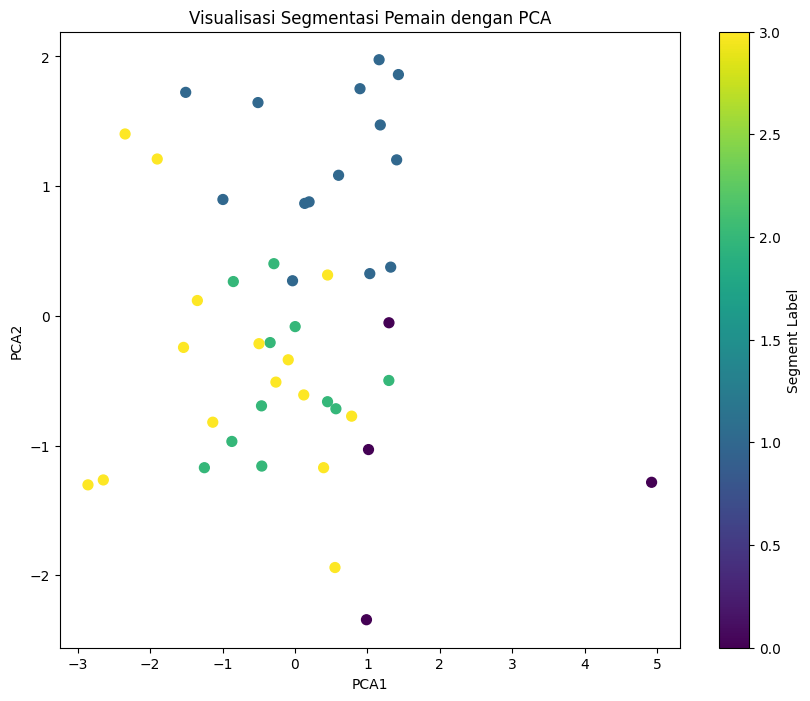

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Menggunakan PCA untuk mereduksi dimensi menjadi 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Menambahkan label segmen ke dalam data PCA
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
X_pca_df["Segment_Label"] = result_df["Segment_Label"]

# Scatter plot berdasarkan hasil PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_df["PCA1"], X_pca_df["PCA2"], c=X_pca_df["Segment_Label"], cmap='viridis', s=50)
plt.colorbar(label='Segment Label')
plt.title("Visualisasi Segmentasi Pemain dengan PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


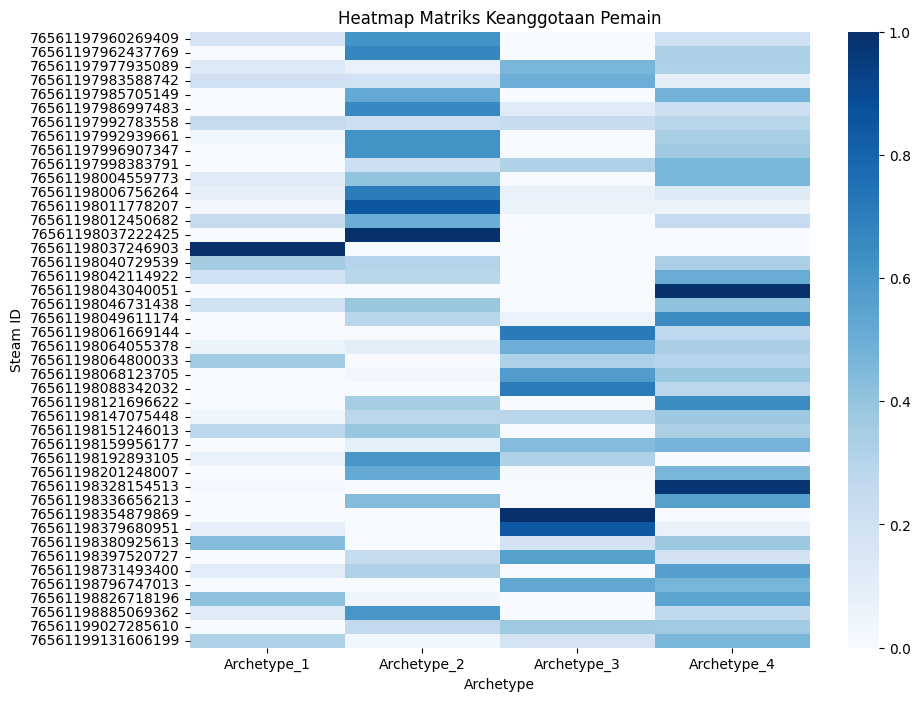

In [ ]:
import seaborn as sns

# Visualisasi matriks keanggotaan (B) sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(B, cmap='Blues', xticklabels=[f'Archetype_{i+1}' for i in range(k)], yticklabels=df['Steam ID'].values, cbar=True)
plt.title("Heatmap Matriks Keanggotaan Pemain")
plt.xlabel("Archetype")
plt.ylabel("Steam ID")
plt.show()


In [ ]:
# Memuat data dari kedua file CSV
seg_result_df = pd.read_csv('segmentation_result.csv')
seg_transformed_df = pd.read_csv('transformed_segmentasi_final.csv')

# Menggabungkan kedua DataFrame berdasarkan Steam ID
merged_df = seg_result_df.merge(seg_transformed_df, on='Steam ID', how='left')

# Menampilkan data gabungan
merged_df.head()


,Steam ID,Archetype_1,Archetype_2,Archetype_3,Archetype_4,Segment_Label,Game_Count,Total_Playtime,Normalized_Playtime,Total_Achievements,Dominant_Genre,Dominant_Genre_Label,Dominant_Topic,Dominant_Topic_Label
0,76561197960269409,0.1780,0.6188,-0.0000,0.2032,1,10,259.4833,0.4818,135,RPG,20,Story-driven mysteries or cinematic adventure ...,18
1,76561197962437769,0.0000,0.6716,0.0000,0.3284,1,9,17.1333,0.0160,34,"Simulation, Strategy",22,Slow-paced narrative games or roguelike indie ...,16
2,76561197977935089,0.1375,0.0752,0.4649,0.3224,2,10,268.5667,0.4992,46,"Action, Adventure",1,Mixed gameplay experience with confusing mecha...,9
3,76561197983588742,0.2099,0.1931,0.4983,0.0986,2,13,204.0333,0.3752,164,"Action, RPG",12,Disappointment with popular titles or sports g...,3
4,76561197985705149,0.0000,0.5207,-0.0000,0.4793,1,8,31.3167,0.0432,40,"Action, Adventure, Indie, RPG",5,Western-themed or poorly paced narrative games,23


In [ ]:
# Membuat fungsi untuk mendapatkan genre dan topik dominan
def get_dominant_genre_topic(group):
    # Mendapatkan genre dan topik dominan
    genres = group['Dominant_Genre'].value_counts().nlargest(3).index.tolist()
    topics = group['Dominant_Topic'].value_counts().nlargest(3).index.tolist()
    return pd.Series({
        'Dominant_Genre': ', '.join(genres),
        'Dominant_Topic': ', '.join(topics)
    })

# Mengelompokkan data berdasarkan archetype dan menghitung rata-rata
result = merged_df.groupby('Segment_Label').agg(
    Avg_Playtime=('Total_Playtime', 'mean'),
    Avg_Owned_Game=('Game_Count', 'mean'),
    Avg_Achievement=('Total_Achievements', 'mean')
)

# Menambahkan genre dan topik dominan untuk setiap archetype
dominant_info = merged_df.groupby('Segment_Label').apply(get_dominant_genre_topic)

# Menggabungkan hasilnya
final_result = result.join(dominant_info)

# Menampilkan hasil akhir
final_result.reset_index(inplace=True)
final_result.rename(columns={'Segment_Label': 'Archetype'}, inplace=True)

# Menyimpan hasil ke dalam file CSV
final_result.to_csv('archetype_characteristics.csv', index=False)

final_result.head()


/var/folders/kh/7d1scz1n2f7gnm2sy2q4rgs00000gn/T/ipykernel_26771/4272588867.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dominant_info = merged_df.groupby('Segment_Label').apply(get_dominant_genre_topic)


,Archetype,Avg_Playtime,Avg_Owned_Game,Avg_Achievement,Dominant_Genre,Dominant_Topic
0,0,326.0667,10.7500,372.0000,"Simulation, Strategy, Indie, Simulation, Strat...",Disappointment with popular titles or sports g...
1,1,143.0595,10.7143,99.4286,"Strategy, RPG, Simulation, Strategy",Western-themed or poorly paced narrative games...
2,2,141.1485,11.1818,80.0909,"Action, Adventure, Action, Action, RPG",Disappointment with popular titles or sports g...
3,3,79.6156,7.6667,120.2667,"Action, Adventure, Action, Action, Indie, RPG",Disappointment with popular titles or sports g...


In [1]:
# Evaluasi Reconstruction Error
# X_scaled ≈ B @ Z

X_reconstructed = B.dot(Z)
reconstruction_error = np.linalg.norm(X_scaled - X_reconstructed, ord='fro') ** 2

print("Reconstruction Error (RE):", reconstruction_error)


NameError: name 'B' is not defined